# Peptide Identification Pipeline using Custom Database

In this project, we aim to develop an algorithm that identifies the microbial composition of a mass spectrometry (MS) sample based on de novo peptide sequencing data. 
Using the predicted peptides, we reconstruct a custom protein sequence database that is optimized for the specific microbial community in the sample.

The pipeline involves several key steps:
- Filtering the de novo peptides based on Average Local Confidence (ALC) scores to retain only high-confidence sequences.
- Cleaning peptide sequences to remove post-translational modification notations.
- Determining the taxonomic origin of peptides by querying UniProt in batch mode.
- Building the microbial community composition based on the taxonomy assignments.
- Constructing a targeted protein database by collecting protein sequences from the identified taxa.
- Reducing database redundancy through clustering to optimize search efficiency and minimize false positives.

By tailoring the database to the actual community composition, we aim to achieve more accurate protein identifications in metaproteomic studies — approaching the performance of genome-based identification strategies, without the need for extensive metagenomic sequencing.

As a first step, we will filter the de novo sequencing results to retain only high-confidence peptides with an Average Local Confidence (ALC) score greater than 70%.

In [1]:
# Import necessary libraries
import pandas as pd

# Load the de novo peptide data
file_path = "de_novo_garmerwolde.csv"
df = pd.read_csv(file_path)

# Display the dataset dimensions
print(f"Original dataset shape: {df.shape}")

# Display rows 24219 to 24227 (Python is zero-indexed → use iloc[24218:24227+1])
print("Original Data (rows 24219–24227):")
display(df.iloc[24218:24228])

# Filter peptides with ALC (%) > 70
filtered_df = df[df["ALC (%)"] > 70]

# Display the filtered dataset dimensions
print(f"Filtered dataset shape: {filtered_df.shape}")

# Display same rows (if they exist after filtering — some will be removed)
print("Filtered Data (rows 24219-24227):")
display(filtered_df.iloc[24218:24228])  # This only works if enough rows remain after filtering
print(f"Number of peptides filtered out: {df.shape[0] - filtered_df.shape[0]}")

Original dataset shape: (189185, 20)
Original Data (rows 24219–24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
24218,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,KYAYFPVWVNDDKMSLPLR,F2:51275,19,76,68,19,781.3988,3,143.42,142.11,0.0,2341.1929,-7.8,NaN,45 39 41 35 33 43 89 98 98 94 95 96 94 90 83 4...,KYAYFPVWVNDDKMSLPLR,HCD
24219,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:35083,MWALDLR,F1:38190,7,76,78,7,452.7394,2,113.16,129.39,34600.0,903.4636,0.6,NaN,56 71 84 79 79 85 90,MWALDLR,HCD
24220,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:98838,LAAALTPAPVLAK,F2:33083,13,76,70,13,618.3896,2,100.95,110.95,13200000.0,1234.7649,-0.2,NaN,48 50 80 99 100 100 99 96 33 31 48 45 82,LAAALTPAPVLAK,HCD
24221,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:83383,APMSGLQNWK,F2:29687,10,76,70,10,566.2845,2,92.40,83.12,215000.0,1130.5542,0.3,NaN,96 94 85 92 82 41 28 21 69 92,APMSGLQNWK,HCD
24222,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:107262,SLTAPSGVPGM(+15.99)FK,F2:26077,13,76,67,13,654.3237,2,83.51,83.66,75700.0,1306.6592,-20.1,Oxidation (M),37 46 79 93 95 96 88 84 23 17 26 89 97,SLTAPSGVPGM(+15.99)FK,HCD
24223,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:139236,EVQAWSWWWM(+15.99)TRRAAMDVPGR,F2:49588,21,76,68,21,879.0955,3,139.45,141.68,822000.0,2634.2371,10.4,Oxidation (M),37 25 33 44 44 41 81 84 90 88 90 40 52 96 95 8...,EVQAWSWWWM(+15.99)TRRAAMDVPGR,HCD
24224,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:3957,MGFYGGR,F2:13573,7,76,68,7,394.1815,2,50.45,47.75,376000.0,786.3483,0.3,NaN,17 29 90 86 80 83 90,MGFYGGR,HCD
24225,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:103943,TLGALDGTN(+.98)MNR,F1:23486,12,76,71,12,632.3035,2,78.32,67.85,3660000.0,1262.5925,0.0,Deamidation (NQ),21 21 26 76 99 98 90 88 70 82 91 93,TLGALDGTN(+.98)MNR,HCD
24226,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:23734,LGGLSSAMK,F1:16822,9,76,75,9,432.2354,2,59.98,63.31,416000.0,862.4582,-2.4,NaN,62 77 48 88 82 73 68 78 97,LGGLSSAMK,HCD
24227,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LDQ(+.98)AHLYNWQWYR,F2:50574,13,76,77,13,897.4365,2,141.76,127.6,0.0,1792.8320,14.8,Deamidation (NQ),31 38 40 61 54 99 98 96 96 94 95 98 100,LDQ(+.98)AHLYNWQWYR,HCD


Filtered dataset shape: (32111, 20)
Filtered Data (rows 24219-24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
25984,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LVTTDANGWYNK,F2:16205,12,75,73,12,691.3395,2,57.63,71.8,0.0,1380.6675,-2.1,NaN,59 60 95 95 95 89 83 70 69 28 43 98,LVTTDANGWYNK,HCD
25985,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:39500,KATSLMDR,F2:7950,8,75,76,8,461.2376,2,32.97,17.78,841000.0,920.4749,-15.5,NaN,77 34 38 87 93 88 96 94,KATSLMDR,HCD
25986,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:103841,WAADLDQ(+.98)MVTK,F2:42699,11,75,75,11,639.8031,2,123.18,107.95,110000.0,1277.5962,-3.6,Deamidation (NQ),78 60 90 90 89 94 89 69 28 41 98,WAADLDQ(+.98)MVTK,HCD
25989,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:18876,Q(+.98)VYLHMDGFR,F1:35026,10,75,72,10,422.8690,3,105.90,95.37,300000.0,1265.5862,-0.9,Deamidation (NQ),26 28 45 61 92 95 98 92 94 96,Q(+.98)VYLHMDGFR,HCD
25990,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:113009,TLLPALYLLQGR,F2:54646,12,75,74,12,679.4126,2,151.38,164.41,25200.0,1356.8130,-1.7,NaN,51 50 50 33 82 89 93 95 85 79 88 98,TLLPALYLLQGR,HCD
25991,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:139595,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,F1:54391,22,75,72,22,847.3984,3,151.74,161.24,6010000.0,2539.1841,-4.2,Deamidation (NQ); Carbamidomethylation,49 40 57 62 82 96 69 44 92 49 28 34 96 97 97 8...,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,HCD
25993,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,-,YHDALTYVWNWGGFTGK,F1:45457,17,75,85,17,1007.9756,2,130.26,163.81,0.0,2013.9373,-0.3,NaN,34 20 62 78 99 99 98 98 98 97 98 97 97 98 98 9...,YHDALTYVWNWGGFTGK,HCD
25994,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:852,NSLAVLR,F1:12592,7,75,81,7,386.7372,2,48.50,66,1480000.0,771.4603,-0.4,NaN,61 60 82 92 94 94 86,NSLAVLR,HCD
25995,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:141090,NYLDDLR,F2:41876,7,75,85,7,908.4518,1,121.32,83.38,208000.0,907.4399,5.0,NaN,85 83 85 82 85 88 90,NYLDDLR,HCD
25997,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:129117,YM(+15.99)APQEVGPGSPFR,F2:34615,14,75,78,14,776.3701,2,104.14,93.71,57400.0,1550.7188,4.5,Oxidation (M),37 35 43 41 90 96 95 97 93 92 94 82 95 100,YM(+15.99)APQEVGPGSPFR,HCD


Number of peptides filtered out: 157074


In [50]:
# Define the wrangle_peptides function
import re

def wrangle_peptides(sequence: str, ptm_filter: bool=True, li_swap: bool=True) -> str:
    """Process peptide sequences by removing post-translational modifications
    and/or equating Leucine and Isoleucine amino acids.

    Args:
        sequence (str): Peptide sequence string
        ptm_filter (bool, optional): Remove PTMs from sequence. Defaults to True.
        li_swap (bool, optional): Equate Leucine (L) and Isoleucine (I). Defaults to True.

    Returns:
        str: Processed sequence string
    """
    if ptm_filter:
        sequence = "".join(re.findall(r"[A-Z]+", sequence))
    if li_swap:
        sequence = sequence.replace("L", "I")
    return sequence

# Apply wrangle_peptides function to the filtered data
filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))

print("Shape of the filtered DataFrame after adding the new column:")
display(filtered_df.shape)  # Check the shape of the DataFrame after adding the new column

# Display rows 11 to 21 (Python is 0-indexed, so need 10:21)
print("Cleaned Peptides (Rows 11–21):")
display(filtered_df[["Peptide", "Cleaned Sequence"]].iloc[10:21])


Shape of the filtered DataFrame after adding the new column:


(32111, 21)

Cleaned Peptides (Rows 11–21):


,Peptide,Cleaned Sequence
10,TSLLN(+.98)YLR,TSIINYIR
11,VVQLTMQ(+.98)TQEK,VVQITMQTQEK
12,ATMSDFSPK,ATMSDFSPK
13,LSELTSLTSAPR,ISEITSITSAPR
14,VSQ(+.98)AVLAASSGR,VSQAVIAASSGR
15,VGLAWDR,VGIAWDR
16,YLPASC(+57.02)R,YIPASCR
17,ASVEDLLK,ASVEDIIK
18,YPDVATTHGGSATK,YPDVATTHGGSATK
19,VMGVAFN(+.98)R,VMGVAFNR


In [3]:
# Import necessary libraries
import requests

# Define the fetch_request function
def fetch_request(url: str, retries: int = 3, delay: int = 5) -> requests.Response:
    """Send GET request and return response object. Retries if server error encountered.

    Args:
        url (str): input URL.
        retries (int, optional): Number of retry attempts. Defaults to 3.
        delay (int, optional): Seconds to wait between retries. Defaults to 5 seconds.

    Raises:
        RuntimeError: If request fails after all retries.

    Returns:
        requests.Response: Response object
    """
    import time  # Import the time module to use sleep delays between retry attempts

    # Loop up to 'retries' times to attempt the request
    for attempt in range(retries):
        req_get = requests.get(url)  # Send a GET request to the provided URL

        if req_get.status_code == 200:
            return req_get  # If the response is successful (HTTP 200), return it immediately

        # If the response was not successful, print a message and wait before retrying
        print(f"Request failed with status {req_get.status_code}. Retrying ({attempt+1}/{retries}) in {delay} seconds...")
        time.sleep(delay)  # Pause for 'delay' seconds before the next attempt

    # If all retry attempts fail, construct an error message using the last received status code
    error_msg = f"Request failed after {retries} retries: statuscode {req_get.status_code}"
    raise RuntimeError(error_msg)  # Raise a RuntimeError to indicate the failure to the calling function

In [4]:
# Define the request_unipept_pept_to_lca function
def request_unipept_pept_to_lca(pept_df: pd.DataFrame, seq_col: str) -> pd.DataFrame:
    """From a dataset of peptides, fetch LCA taxonomy and rank from UniPept database.

    Args:
        pept_df (pd.DataFrame): Peptide dataset.
        seq_col (str): Column with peptide sequences.

    Returns:
        pd.DataFrame: Peptide sequences with LCA taxonomy and LCA rank.
    """
    # Base URL for the UniPept pept2lca API with equate_il=true (I and L treated as equal)
    base_url = "http://api.unipept.ugent.be/api/v1/pept2lca.json?equate_il=true"

    # Number of peptides to include per API request (due to API limits)
    batch_size = 100

    # Create a list of unique peptide strings in the correct API format: '&input[]=PEPTIDE'
    seq_series = ["&input[]=" + seq for seq in pept_df[seq_col].drop_duplicates()]

    # Initialize an empty DataFrame to collect all LCA results
    lca_df = pd.DataFrame(columns=[seq_col, "Global LCA", "Global LCA Rank"], dtype=object)

    # x is the index for batching through seq_series
    x = 0
    while True:
        # Get the next batch of peptides for the current request
        if x + batch_size >= len(seq_series):
            peptides = seq_series[x:]  # Last batch (may be smaller than batch_size)
        else:
            peptides = seq_series[x:x+batch_size]  # Normal batch of size 100

        # Concatenate the base URL with the batch of peptides to form the full request string
        req_str = "".join([base_url, *peptides])

        # Send the HTTP request and parse the JSON response
        response = fetch_request(req_str).json()

        # Convert each item in the response into a row in the DataFrame
        # Use `.get()` with default value "Unknown" in case a field is missing
        lca_df = pd.concat([
            lca_df,
            pd.DataFrame(
                [
                    (
                        elem.get("peptide", "Unknown"),     # peptide sequence
                        elem.get("taxon_id", "Unknown"),    # taxon ID (LCA)
                        elem.get("taxon_rank", "Unknown")   # taxonomic rank of LCA
                    )
                    for elem in response
                ],
                columns=[seq_col, "Global LCA", "Global LCA Rank"]
            )
        ])

        # Move the index forward by the batch size
        x += batch_size

        # Break the loop when all peptides have been processed
        if x >= len(seq_series):
            break

    # Return the full DataFrame with LCA results for all input peptides
    return lca_df

In [5]:
# Now run the function on our cleaned peptide dataset
# We pass filtered_df with the 'Cleaned Sequence' column

print("Fetching taxonomy information from UniPept...")
lca_results_df = request_unipept_pept_to_lca(filtered_df, seq_col="Cleaned Sequence")

# Display the first few results
print("LCA Mapping Results:")
display(lca_results_df.head())

Fetching taxonomy information from UniPept...
LCA Mapping Results:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
2,ITGMAFR,1,no rank
3,IGSDAYNQK,3379134,kingdom
4,IGATYDIFGDGK,1,no rank


In [6]:
# Display the lca dataset dimensions
print(f"LCA results dataset shape: {lca_results_df.shape}")

LCA results dataset shape: (8703, 3)


Now that we have obtained the taxonomic assignments for our peptides in the lca_results_df dataset, we want to examine how many peptides were classified at each taxonomic rank (e.g., species, genus, family).
This helps us evaluate the overall resolution of our data and determine which rank is most appropriate for downstream analysis and visualization of the microbial community composition.

In [7]:
# Count the number of peptides per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Display the counts
print("Peptide counts per LCA rank:")
display(rank_counts)

Peptide counts per LCA rank:


Global LCA Rank
no rank          6610
species           824
domain            356
genus             268
class             142
strain            126
phylum            115
kingdom           109
family             61
order              36
subphylum          10
subfamily           8
subclass            7
subkingdom          6
subspecies          5
subgenus            5
infraorder          5
superclass          4
species group       3
suborder            1
tribe               1
varietas            1
Name: count, dtype: int64

In [8]:
# This code allows us to automatically define the allowed_ranks based on the frequency of occurrence in the dataset.
# Step 1: Replace 'no rank' with 'Unclassified' for clarity
lca_results_df["Global LCA Rank"] = lca_results_df["Global LCA Rank"].replace("no rank", "Unclassified")

# Step 2: Count how many peptides exist per LCA rank
rank_counts = lca_results_df["Global LCA Rank"].value_counts()

# Step 3: Define canonical rank order (from general to specific)
canonical_rank_order = [
    "domain", "kingdom", "subkingdom", "superclass", "phylum", "subphylum",
    "class", "subclass", "order", "suborder", "infraorder", "family", "subfamily",
    "genus", "subgenus", "species group", "species", "subspecies",
    "strain", "varietas", "tribe"
]

# Step 4: Filter canonical ranks based on frequency threshold
rank_frequency_cutoff = 15
allowed_ranks = [rank for rank in canonical_rank_order if rank_counts.get(rank, 0) >= rank_frequency_cutoff]

# Step 5: Print the allowed ranks to verify order and contents
print("Allowed ranks based on cutoff and specificity:")
print(allowed_ranks)

# Step 6: Filter the DataFrame to only include allowed ranks
filtered_lca_df = lca_results_df[lca_results_df["Global LCA Rank"].isin(allowed_ranks)].copy()

# Step 7: Count how many times each taxon ID appears
taxon_counts = filtered_lca_df["Global LCA"].value_counts()

# Step 8: Apply a frequency cutoff (e.g. at least 10 peptides per taxon ID)
taxa_to_keep = taxon_counts[taxon_counts >= 10].index

# Step 9: Keep only rows with a frequently occurring taxon ID
filtered_lca_df = filtered_lca_df[filtered_lca_df["Global LCA"].isin(taxa_to_keep)]

# Summary printout
print(f"\nFiltered dataset shape: {filtered_lca_df.shape}")
print("Preview of filtered dataset:")
display(filtered_lca_df.head())


Allowed ranks based on cutoff and specificity:
['domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']

Filtered dataset shape: (1005, 3)
Preview of filtered dataset:


,Cleaned Sequence,Global LCA,Global LCA Rank
0,AISTWFTIK,1234,genus
1,MAGSQTAMTR,327159,genus
3,IGSDAYNQK,3379134,kingdom
6,ISAVGEVYDIK,1400863,strain
8,ATMSDFSPK,327160,species


In [9]:
# Some test code to check if the scientific name is present in the response
taxon_id = 1234
url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
params = {
    "db": "taxonomy",
    "id": taxon_id,
    "retmode": "json"
}

response = requests.get(url, params=params)
print("Status code:", response.status_code)
print(response.json())  # <- This should contain 'scientificname'


Status code: 200
{'header': {'type': 'esummary', 'version': '0.3'}, 'result': {'uids': ['1234'], '1234': {'uid': '1234', 'status': 'active', 'rank': 'genus', 'division': 'bacteria', 'scientificname': 'Nitrospira', 'commonname': '', 'taxid': 1234, 'akataxid': '', 'genus': '', 'species': '', 'subsp': '', 'modificationdate': '2015/08/12 00:00', 'genbankdivision': 'Bacteria'}}}


In [10]:
import requests
import time

# Step 1: Get unique taxon IDs from the filtered dataframe
unique_taxa = filtered_lca_df["Global LCA"].unique()

# Step 2: Define a dictionary to store Taxon ID → Scientific Name
taxon_to_name = {}

# Step 3: Query NCBI Entrez API for each taxon ID
# Loop through each unique taxon ID to fetch its scientific name from the NCBI Entrez taxonomy database
for taxon_id in unique_taxa:
    try:
        # Define the NCBI Entrez API endpoint for taxonomy summary
        url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
        
        # Define the query parameters: specify the taxonomy database, taxon ID, and request JSON format
        params = {
            "db": "taxonomy",     # we're querying the taxonomy database
            "id": taxon_id,       # the current taxon ID we want to look up
            "retmode": "json"     # return the results in JSON format
        }

        # Send the GET request to the NCBI Entrez API with the defined parameters
        response = requests.get(url, params=params)
        
        # Parse the JSON response from the API
        data = response.json()
        
        # Safely get the "result" dictionary from the JSON response
        result = data.get("result", {})

        # Check if the taxon ID is present in the results
        if str(taxon_id) in result:
            # Extract the scientific name from the response using the taxon ID as the key
            sci_name = result[str(taxon_id)].get("scientificname", "Unknown")
            # Store the scientific name in the dictionary with the taxon ID as the key
            taxon_to_name[taxon_id] = sci_name
        else:
            # If the taxon ID is not found in the results, store "Unknown" as the name
            taxon_to_name[taxon_id] = "Unknown"

    except Exception as e:
        # If any error occurs during the request or parsing, record "Error" as the name
        taxon_to_name[taxon_id] = "Error"
    
    # Wait 0.2 seconds before the next request to avoid overwhelming the API (rate limiting)
    time.sleep(0.2)

# Step 4: Map scientific names back into a new dataframe
filtered_lca_named_df = filtered_lca_df.copy()
filtered_lca_named_df["Scientific Name"] = filtered_lca_named_df["Global LCA"].map(taxon_to_name)

# Step 5: Preview the new dataframe
print("Preview of dataframe with scientific names:")
display(filtered_lca_named_df)


Preview of dataframe with scientific names:


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name
0,AISTWFTIK,1234,genus,Nitrospira
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter
3,IGSDAYNQK,3379134,kingdom,Pseudomonadati
6,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11
8,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis
...,...,...,...,...
16,FAAACQQK,2,domain,Bacteria
25,FIEISWPK,2759,domain,Eukaryota
28,GNSDVGFR,2759,domain,Eukaryota
16,ASVIFMPK,2759,domain,Eukaryota


In [11]:
# Count how many rows have missing or invalid taxon IDs (e.g., NaN or 'Unknown')
num_missing_taxa = filtered_lca_named_df["Global LCA"].isna().sum() + (filtered_lca_named_df["Global LCA"] == "Unknown").sum()
print(f"Number of rows with missing or 'Unknown' taxon IDs: {num_missing_taxa}")

# Count duplicates: total - number of unique
total_taxa = filtered_lca_named_df["Global LCA"].nunique(dropna=True)
num_duplicates = filtered_lca_named_df["Global LCA"].count() - total_taxa
print(f"Number of duplicate taxon ID entries: {num_duplicates}")

Number of rows with missing or 'Unknown' taxon IDs: 0
Number of duplicate taxon ID entries: 983


In [12]:
# Original fetch lineage code, but gives NA values where it shouldn't and has strain and species reversed.
''' 
import xml.etree.ElementTree as ET

# Step 1: Get unique taxon IDs from your DataFrame
taxon_ids = filtered_lca_named_df["Global LCA"].dropna().unique()

# Step 2: Create an empty dictionary to store taxon ID → lineage mapping
taxon_lineages = {}

# Step 3: Function to fetch lineage from NCBI Entrez
# Define a function to fetch the full taxonomic lineage (e.g., phylum, class, genus, etc.) from NCBI for a given taxon ID
def fetch_lineage(taxon_id):
    # Define the NCBI Entrez efetch API endpoint for taxonomy
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    
    # Define the parameters for the API request:
    # - db: database to query ('taxonomy')
    # - id: the taxon ID to look up
    # - retmode: return data as XML so we can parse it
    params = {
        "db": "taxonomy",
        "id": str(taxon_id),
        "retmode": "xml"
    }

    try:
        # Send a GET request to the NCBI API
        response = requests.get(url, params=params)

        # Parse the returned XML content into an ElementTree object
        root = ET.fromstring(response.content)

        # Initialize an empty dictionary to store rank → scientific name mappings
        lineage_dict = {}

        # Find all <Taxon> elements in the XML tree (usually one, but handles multiple if present)
        for taxon in root.findall(".//Taxon"):
            # Extract the taxonomic rank (e.g., genus, family, phylum, etc.)
            rank = taxon.find("Rank")
            # Extract the corresponding scientific name
            name = taxon.find("ScientificName")

            # Only add to dictionary if both rank and name are present and the rank is not "no rank"
            if rank is not None and name is not None and rank.text != "no rank":
                # Convert rank to lowercase and store it as a key with its corresponding name
                lineage_dict[rank.text.lower()] = name.text

        # Return the final dictionary for this taxon ID
        return lineage_dict

    except Exception as e:
        # Print the error message if the request or parsing fails
        print(f"Error with taxon ID {taxon_id}: {e}")
        # Return an empty dictionary in case of failure
        return {}

# Step 4: Loop through all taxon IDs and build the dictionary
for tid in taxon_ids:
    taxon_lineages[tid] = fetch_lineage(tid)
    time.sleep(0.3)  # to avoid overwhelming the server

# Optional: Display the result as a table
import pandas as pd
lineage_df = pd.DataFrame.from_dict(taxon_lineages, orient="index").fillna("NA")
display(lineage_df.head())
'''


' \nimport xml.etree.ElementTree as ET\n\n# Step 1: Get unique taxon IDs from your DataFrame\ntaxon_ids = filtered_lca_named_df["Global LCA"].dropna().unique()\n\n# Step 2: Create an empty dictionary to store taxon ID → lineage mapping\ntaxon_lineages = {}\n\n# Step 3: Function to fetch lineage from NCBI Entrez\n# Define a function to fetch the full taxonomic lineage (e.g., phylum, class, genus, etc.) from NCBI for a given taxon ID\ndef fetch_lineage(taxon_id):\n    # Define the NCBI Entrez efetch API endpoint for taxonomy\n    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"\n    \n    # Define the parameters for the API request:\n    # - db: database to query (\'taxonomy\')\n    # - id: the taxon ID to look up\n    # - retmode: return data as XML so we can parse it\n    params = {\n        "db": "taxonomy",\n        "id": str(taxon_id),\n        "retmode": "xml"\n    }\n\n    try:\n        # Send a GET request to the NCBI API\n        response = requests.get(url, par

In [13]:
# This fetch lineage code replaces the NA values with the first more specific taxon available in the lineage.
# It also swaps strain and species, and removes 'clade' if it exists.
import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd

# Step 1: Get unique taxon IDs
taxon_ids = filtered_lca_named_df["Global LCA"].dropna().unique()

# Step 2: Create an empty dictionary for taxon ID → lineage mapping
taxon_lineages = {}

# Step 3: Function to fetch the full taxonomic lineage
def fetch_lineage(taxon_id):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "taxonomy",
        "id": str(taxon_id),
        "retmode": "xml"
    }

    try:
        response = requests.get(url, params=params)
        root = ET.fromstring(response.content)
        lineage_dict = {}
        for taxon in root.findall(".//Taxon"):
            rank = taxon.find("Rank")
            name = taxon.find("ScientificName")
            if rank is not None and name is not None and rank.text != "no rank":
                lineage_dict[rank.text.lower()] = name.text
        return lineage_dict
    except Exception as e:
        print(f"Error with taxon ID {taxon_id}: {e}")
        return {}

# Step 4: Fetch lineages for all taxon IDs
for tid in taxon_ids:
    taxon_lineages[tid] = fetch_lineage(tid)
    time.sleep(0.3)  # prevent hammering the server

# Step 5: Create DataFrame from dictionary
lineage_df = pd.DataFrame.from_dict(taxon_lineages, orient="index")

# Step 6: Reorder columns (strain comes after species), remove 'clade' if it exists
cols = ['cellular root', 'domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']
existing_cols = [col for col in cols if col in lineage_df.columns]
lineage_df = lineage_df[existing_cols].fillna("NA")  # temporarily fill NA for logic

# Step 7: Backfill NA values using more specific taxa (bottom-up propagation)
def propagate_taxonomy(row):
    # Work backwards from most specific to general
    reversed_cols = list(reversed(existing_cols))
    current_value = None
    for col in reversed_cols:
        if row[col] != "NA":
            current_value = row[col]
        elif current_value is not None:
            row[col] = current_value
    return row

lineage_df = lineage_df.apply(propagate_taxonomy, axis=1)

# Step 8: Final clean-up (remove 'clade' if it’s still around)
if 'clade' in lineage_df.columns:
    lineage_df.drop(columns=['clade'], inplace=True)

# Step 9: Display final result
display(lineage_df.head())

,cellular root,domain,kingdom,phylum,class,order,family,genus,species,strain
1234,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,NA,NA
327159,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,NA,NA
1400863,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Candidatus Competibacteraceae,Candidatus Competibacteraceae,Candidatus Competibacter,Candidatus Competibacter denitrificans,Candidatus Competibacter denitrificans Run_A_D11
327160,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter phosphatis,NA
330214,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,Nitrospira defluvii,NA


In [14]:
print(filtered_lca_named_df.shape)
print(lineage_df.shape)
print(len(taxon_ids)) # it seems that the majority of the taxon IDs are duplicates of each other (983 out of 1005)

(1005, 4)
(22, 10)
22


In [15]:
lineage_df = lineage_df.reset_index().rename(columns={"index": "Global LCA"})
merged_df = filtered_lca_named_df.merge(lineage_df, on="Global LCA", how="left")
print(merged_df.shape)
display(merged_df.head())

(1005, 14)


,Cleaned Sequence,Global LCA,Global LCA Rank,Scientific Name,cellular root,domain,kingdom,phylum,class,order,family,genus,species,strain
0,AISTWFTIK,1234,genus,Nitrospira,cellular organisms,Bacteria,Pseudomonadati,Nitrospirota,Nitrospiria,Nitrospirales,Nitrospiraceae,Nitrospira,NA,NA
1,MAGSQTAMTR,327159,genus,Candidatus Accumulibacter,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,NA,NA
2,IGSDAYNQK,3379134,kingdom,Pseudomonadati,cellular organisms,Bacteria,Pseudomonadati,NA,NA,NA,NA,NA,NA,NA
3,ISAVGEVYDIK,1400863,strain,Candidatus Competibacter denitrificans Run_A_D11,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Candidatus Competibacteraceae,Candidatus Competibacteraceae,Candidatus Competibacter,Candidatus Competibacter denitrificans,Candidatus Competibacter denitrificans Run_A_D11
4,ATMSDFSPK,327160,species,Candidatus Accumulibacter phosphatis,cellular organisms,Bacteria,Pseudomonadati,Pseudomonadota,Betaproteobacteria,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter,Candidatus Accumulibacter phosphatis,NA


In [16]:
def assign_taxonomic_label(df: pd.DataFrame, target_rank: str) -> pd.Series:
    """
    Assigns each row in the DataFrame to a taxonomic label at the specified rank.

    If a peptide is annotated at or below the target rank, it will be assigned
    the label from that rank. If not, it will be labeled as 'Unclassified'.

    Parameters:
        df (pd.DataFrame): DataFrame containing taxonomic lineage columns.
        target_rank (str): The desired rank to group peptides by (e.g., 'phylum', 'kingdom').

    Returns:
        pd.Series: A column with assigned labels for each peptide at the given rank.
    """
    if target_rank not in df.columns:
        raise ValueError(f"Target rank '{target_rank}' not found in the dataframe columns.")
    
    return df[target_rank].fillna("Unclassified").replace("NA", "Unclassified")


In [17]:
# List of considered ranks (same as in your allowed_ranks + others you may want to evaluate)
ranks_to_check = allowed_ranks

# Dictionary to store results
rank_label_counts = {}

# Loop through each rank and count peptides per label
for target_rank in ranks_to_check:
    try:
        # Assign a label for the current rank
        labels = assign_taxonomic_label(merged_df, target_rank)
        
        # Count the number of peptides per label
        label_counts = labels.value_counts().sort_values(ascending=False)
        
        # Store the result
        rank_label_counts[target_rank] = label_counts
    except Exception as e:
        print(f"Error processing rank '{target_rank}': {e}")

In [18]:
# Display the counts for the phylum level as a test
print("Peptide counts at phylum level:")
display(rank_label_counts["phylum"])
 
print("Peptide counts at domain level:")
display(rank_label_counts["domain"])

Peptide counts at phylum level:


phylum
Pseudomonadota    464
Unclassified      462
Nitrospirota       46
Actinomycetota     23
Bacteroidota       10
Name: count, dtype: int64

Peptide counts at domain level:


domain
Bacteria     837
Eukaryota    168
Name: count, dtype: int64

An important remark to make: We do not consider the unclassified peptides outside of the domain level, as they are not informative for the analysis. This means that the majority of our peptides (6610 out of the total, which is 76%) are not used for determining the community composition. Since these "no rank" peptides could have been informative, if they were ranked, we cannot conclude our obtained community composition with certainty, since only 24% of the peptides are ranked and thus informative. Also, we cannot guarantee that all the possible peptides in our sample are actually analyzed in the MS. So, we might already miss some proteins during the LC-tandem mass spectrometry procedure, which means our csv dataset is not complete per definition.  

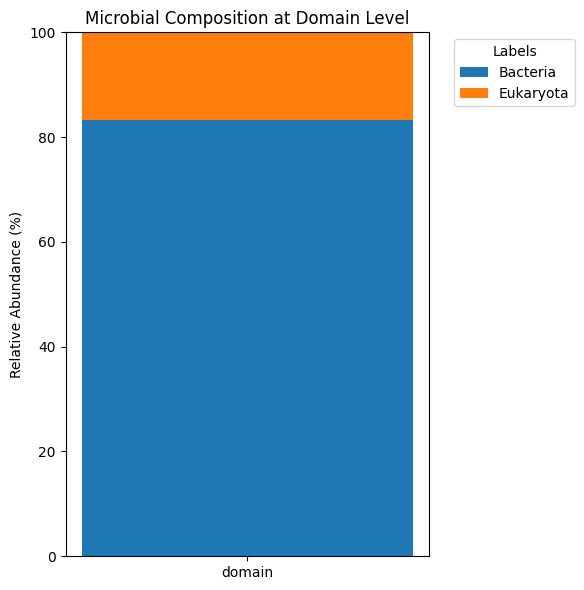

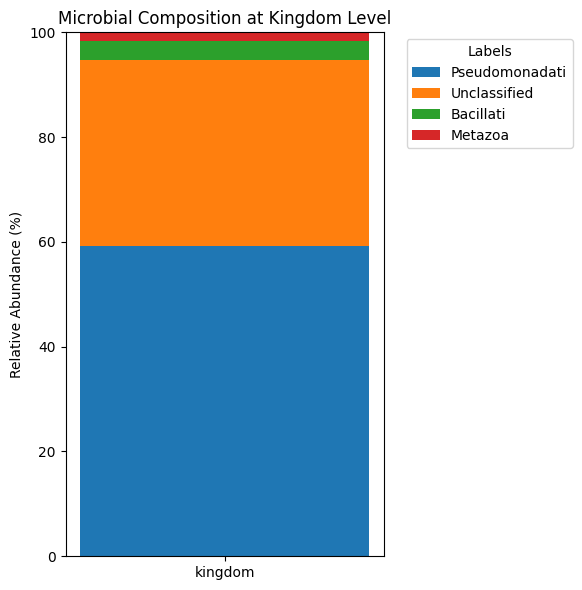

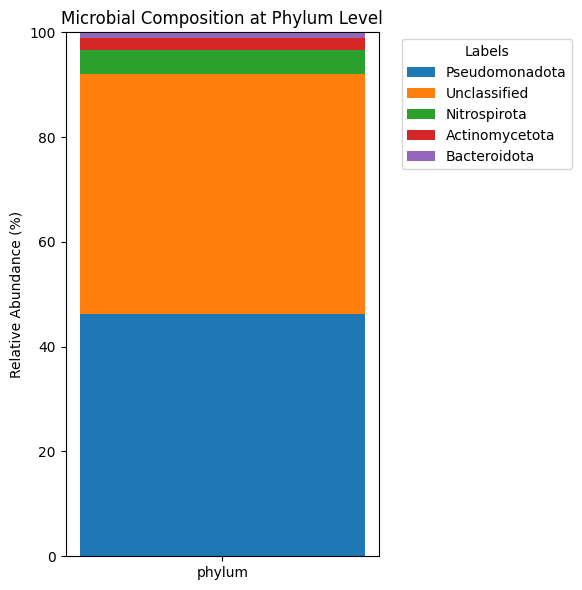

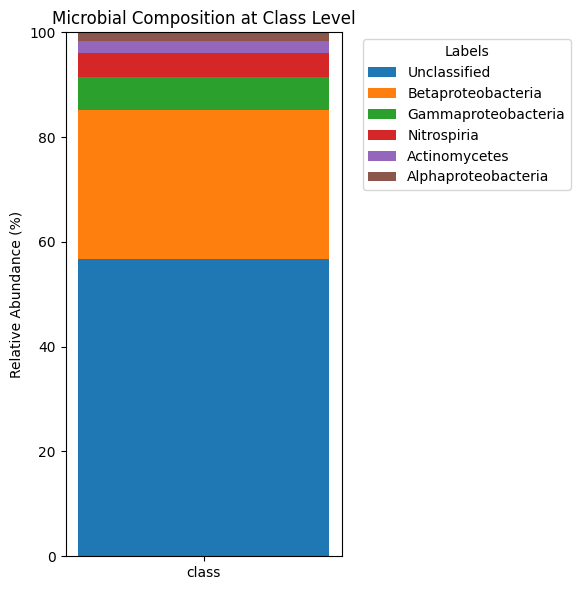

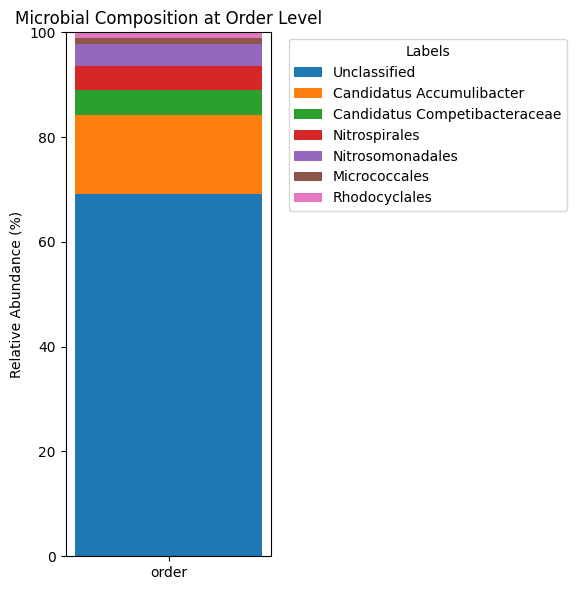

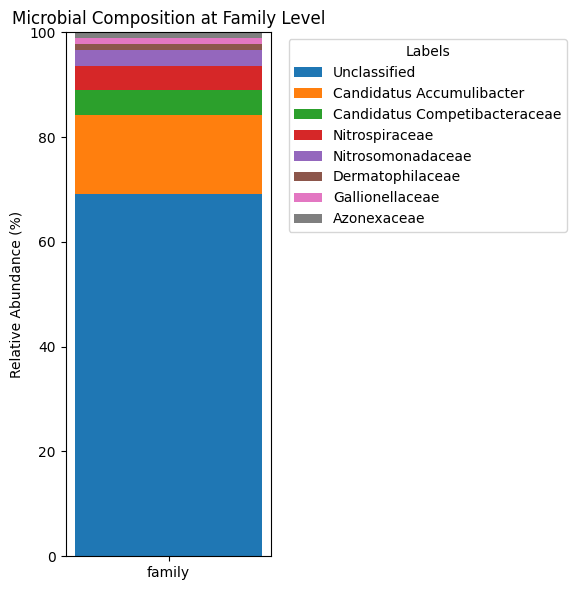

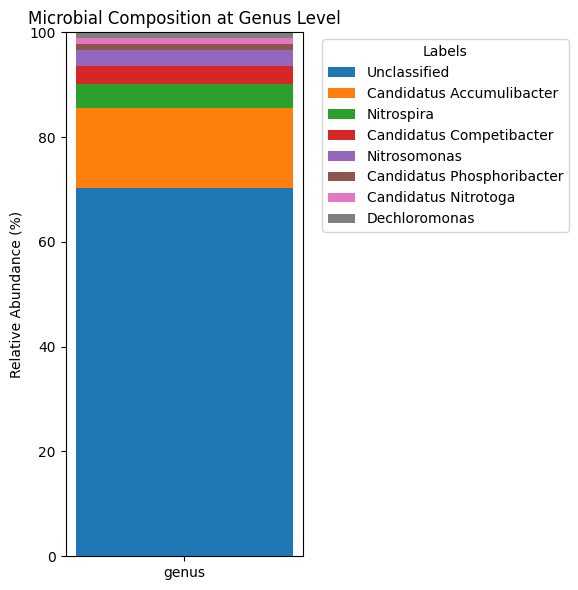

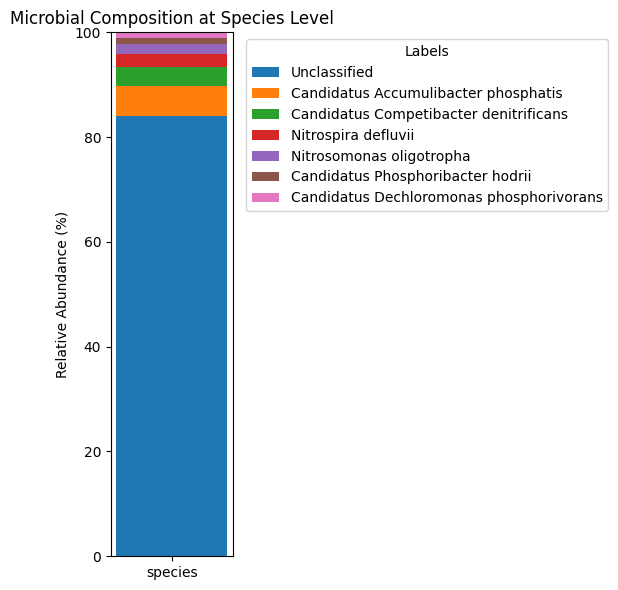

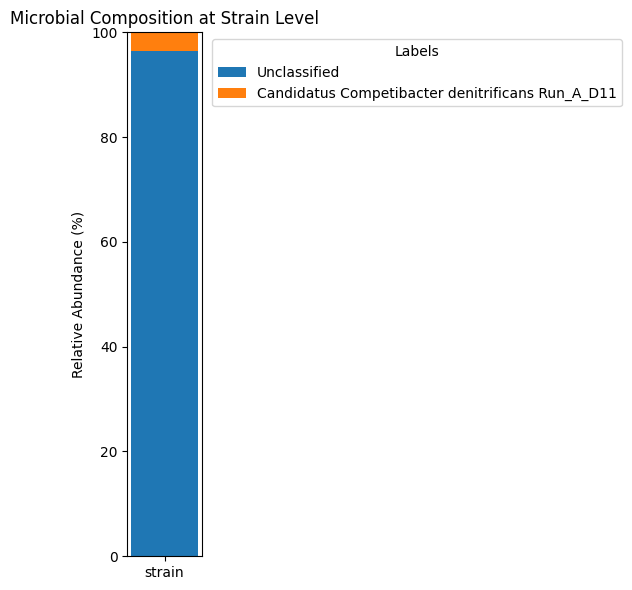

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Step: Loop through each rank and create a stacked bar chart
for rank, label_counts in rank_label_counts.items():
    # Convert the label counts (Series) to a DataFrame with percentages
    df = label_counts.reset_index()
    df.columns = ["Label", "Count"]
    df["Percent"] = df["Count"] / df["Count"].sum() * 100

    # Sort labels by abundance for consistent stacking
    df = df.sort_values(by="Percent", ascending=False)

    # Plot settings
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a single stacked bar for the current rank
    bottom = 0
    for _, row in df.iterrows():
        ax.bar(rank, row["Percent"], bottom=bottom, label=row["Label"])
        bottom += row["Percent"]

    # Final adjustments
    ax.set_title(f"Microbial Composition at {rank.capitalize()} Level")
    ax.set_ylabel("Relative Abundance (%)")
    ax.set_ylim(0, 100)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")

    plt.tight_layout()
    plt.show()

Now that we have identified our community composition at differnt rank levels, we want to create a custom database that contains only protein sequences from taxa that were confidently identified as most abundant in our sample. This is because we want to: maximize coverage of relevant proteins from the dominant community members, minimize false positives (FDR), because we exclude unrelated/unlikely taxa from global reference databases and speed up downstream database searching (smaller DB → faster and more accurate MS search)

In [20]:
import os
from datetime import datetime

In [21]:
'''
# This script downloads FASTA sequences for the top taxa (most common Glocal LCA taxon IDs) in the filtered dataset, REGARDLESS OF RANK.
from datetime import datetime

def download_uniprot_fasta_by_taxid(taxon_id, taxon_name, output_dir="fasta_proteomes", reviewed=True, max_entries=500):
    """
    Download protein FASTA sequences from UniProt using NCBI Taxon ID.
    Saves files in a session-specific folder.
    """
    os.makedirs(output_dir, exist_ok=True)
    reviewed_str = "reviewed:true" if reviewed else "reviewed:false"
    
    query = f'taxonomy_id:{taxon_id} AND {reviewed_str}'
    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={max_entries}"

    try:
        print(f"Fetching proteins for taxon: {taxon_name} (ID: {taxon_id})")
        response = requests.get(url)

        if response.status_code == 200 and response.text.strip():
            file_name = f"{taxon_name.replace(' ', '_')}_{taxon_id}.fasta"
            with open(os.path.join(output_dir, file_name), "w") as f:
                f.write(response.text)
            print(f"✅ Saved to {file_name}\n")
        else:
            print(f"❌ No proteins found (Status: {response.status_code})\n")
    except Exception as e:
        print(f"❌ Error for {taxon_name}: {e}")
        

# === Create new session folder ===
base_dir = "fasta_proteomes"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
session_dir = os.path.join(base_dir, f"session_{timestamp}")
os.makedirs(session_dir, exist_ok=True)
print(f"🔖 Created output folder: {session_dir}\n")

# === Get top taxa and names ===
top_taxa = filtered_lca_named_df["Global LCA"].value_counts().head(5).index.tolist()
taxon_id_to_name = filtered_lca_named_df.set_index("Global LCA")["Scientific Name"].to_dict()

for tid in top_taxa:
    name = taxon_id_to_name.get(tid, f"taxon_{tid}")
    if name != "Unclassified":
        download_uniprot_fasta_by_taxid(tid, name, output_dir=session_dir)
'''

'\n# This script downloads FASTA sequences for the top taxa (most common Glocal LCA taxon IDs) in the filtered dataset, REGARDLESS OF RANK.\nfrom datetime import datetime\n\ndef download_uniprot_fasta_by_taxid(taxon_id, taxon_name, output_dir="fasta_proteomes", reviewed=True, max_entries=500):\n    """\n    Download protein FASTA sequences from UniProt using NCBI Taxon ID.\n    Saves files in a session-specific folder.\n    """\n    os.makedirs(output_dir, exist_ok=True)\n    reviewed_str = "reviewed:true" if reviewed else "reviewed:false"\n    \n    query = f\'taxonomy_id:{taxon_id} AND {reviewed_str}\'\n    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={max_entries}"\n\n    try:\n        print(f"Fetching proteins for taxon: {taxon_name} (ID: {taxon_id})")\n        response = requests.get(url)\n\n        if response.status_code == 200 and response.text.strip():\n            file_name = f"{taxon_name.replace(\' \', \'_\')}_{taxon_id}.fasta"\n        

In [22]:
def download_uniprot_fasta(organism_name, taxon_id, label, output_dir):
    """
    Try to download FASTA proteins from UniProt by organism name, fall back to taxon ID.
    Save the FASTA to the given output directory.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    
    # First try by scientific name
    query_by_name = f'organism_name:"{organism_name}"'
    query_by_taxid = f'organism_id:{taxon_id}'

    headers = {"User-Agent": "Mozilla/5.0"}
    params = {"query": query_by_name, "format": "fasta", "size": 500}
    
    try:
        response = requests.get(base_url, headers=headers, params=params)
        if response.ok and len(response.text.strip()) > 0:
            filename = f"{label.replace(' ', '_')}.fasta"
            with open(os.path.join(output_dir, filename), "w") as f:
                f.write(response.text)
            print(f"✅ Saved proteins for {label} using scientific name.")
            return
        else:
            print(f"⚠️ No proteins found for {label} by name. Trying taxon ID...")
        
        # Retry with taxon ID if scientific name failed
        params["query"] = query_by_taxid
        response = requests.get(base_url, headers=headers, params=params)
        if response.ok and len(response.text.strip()) > 0:
            filename = f"{label.replace(' ', '_')}.fasta"
            with open(os.path.join(output_dir, filename), "w") as f:
                f.write(response.text)
            print(f"✅ Saved proteins for {label} using taxon ID.")
        else:
            print(f"❌ No proteins found for {label} (Status: {response.status_code})")
    
    except Exception as e:
        print(f"❌ Error fetching proteins for {label}: {e}")

In [23]:
# You can use this function to download FASTA files for the TOP TAXA
'''
top_n = 7               # number of top taxa to download
# === Step 2: Count top N most abundant taxa at this rank ===
top_labels = merged_df[f"{target_rank}_label"].value_counts().head(top_n).index.tolist() 
'''

'\ntop_n = 7               # number of top taxa to download\n# === Step 2: Count top N most abundant taxa at this rank ===\ntop_labels = merged_df[f"{target_rank}_label"].value_counts().head(top_n).index.tolist() \n'

In [24]:
'''
# Your lineage_df has scientific names in e.g. species column
target_rank = "species"

# Use all unique classified taxa at the target rank (excluding 'Unclassified' and NA)
top_labels = merged_df[f"{target_rank}_label"].dropna().unique().tolist()
top_labels = [label for label in top_labels if label != "Unclassified"]

# Create session folder
import datetime
session_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"fasta_proteomes/session_{session_time}"
os.makedirs(output_dir, exist_ok=True)

label_to_taxid = {}
label_to_name = {}

for tid, row in lineage_df.iterrows():
    label = row.get(target_rank)
    if label in top_labels:
        label_to_taxid[label] = tid
        label_to_name[label] = row.get(target_rank)  # scientific name at that rank

# Loop over labels to fetch FASTA files using improved logic
for label in top_labels:
    if label != "Unclassified" and label in label_to_taxid:
        tid = label_to_taxid[label]
        organism_name = label_to_name[label]
        download_uniprot_fasta(organism_name, tid, label, output_dir)
'''

'\n# Your lineage_df has scientific names in e.g. species column\ntarget_rank = "species"\n\n# Use all unique classified taxa at the target rank (excluding \'Unclassified\' and NA)\ntop_labels = merged_df[f"{target_rank}_label"].dropna().unique().tolist()\ntop_labels = [label for label in top_labels if label != "Unclassified"]\n\n# Create session folder\nimport datetime\nsession_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")\noutput_dir = f"fasta_proteomes/session_{session_time}"\nos.makedirs(output_dir, exist_ok=True)\n\nlabel_to_taxid = {}\nlabel_to_name = {}\n\nfor tid, row in lineage_df.iterrows():\n    label = row.get(target_rank)\n    if label in top_labels:\n        label_to_taxid[label] = tid\n        label_to_name[label] = row.get(target_rank)  # scientific name at that rank\n\n# Loop over labels to fetch FASTA files using improved logic\nfor label in top_labels:\n    if label != "Unclassified" and label in label_to_taxid:\n        tid = label_to_taxid[label]\n  

In [25]:
# This function merges all FASTA files in a session folder into a single FASTA database.
def merge_fasta_files(session_folder, output_file="custom_database.fasta"):
    """
    Merge all FASTA files in a session folder into a single FASTA database.
    
    Args:
        session_folder (str): Path to the session directory with FASTA files.
        output_file (str): Name of the merged output FASTA file.
    """
    # Output path for the merged FASTA
    output_path = os.path.join(session_folder, output_file)

    with open(output_path, "w") as outfile:
        for file in os.listdir(session_folder):
            if file.endswith(".fasta"):
                fasta_path = os.path.join(session_folder, file)
                with open(fasta_path, "r") as infile:
                    outfile.write(infile.read())
                    outfile.write("\n")  # Ensure separation between files

    print(f"✅ Merged FASTA saved to: {output_path}")


In [26]:
# === Merge FASTA files from the same session folder used for download ===
#merge_fasta_files(output_dir)  # This reuses the folder already created above

In [ ]:
# Clustering the proteins in the merged FASTA file using MMseqs in WSL (Windows Subsystem for Linux)
import subprocess

commands = [
    'wsl mmseqs createdb /mnt/c/Users/Yusuf/OneDrive/LST/Derde_jaar/Y3Q4/Pipeline/fasta_proteomes/session_2025-05-07_16-54-35/custom_database_species.fasta custom_db',
    'wsl mmseqs cluster custom_db clustered_db tmp --min-seq-id 0.9',
    'wsl mmseqs createseqfiledb custom_db clustered_db clustered_db_seq',
    'wsl mmseqs result2flat custom_db custom_db clustered_db_seq /mnt/c/Users/Yusuf/OneDrive/LST/Derde_jaar/Y3Q4/Pipeline/fasta_proteomes/session_2025-05-07_16-54-35/custom_database_species_clustered90.fasta'
]

for cmd in commands:
    subprocess.run(cmd, shell=True, check=True)

In [ ]:
# Clustering the proteins in the merged FASTA file using MMseqs in WSL (Windows Subsystem for Linux)
# Make sure that WSL (eg Ubuntu) and MMseqs2 are installed and accessible via wsl mmseqs
import os
import subprocess

# Define the parent and session folders
base_dir = "fasta_proteomes"

# Identify the latest session folder
session_dirs = sorted(
    [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith("session_")],
    key=os.path.getmtime,
    reverse=True
)
latest_session = session_dirs[0]
print(f"🟢 Latest session folder: {latest_session}")

# Input and output FASTA paths
input_fasta = os.path.join(latest_session, "custom_database_species.fasta")
output_fasta = os.path.join(latest_session, "custom_database_species_clustered90.fasta")

# Format for WSL path
wsl_input = input_fasta.replace("\\", "/").replace("C:", "/mnt/c")
wsl_output = output_fasta.replace("\\", "/").replace("C:", "/mnt/c")
wsl_folder = os.path.dirname(wsl_input)

# Commands for MMseqs2
commands = [
    f'wsl mmseqs createdb {wsl_input} custom_db',
    'wsl mmseqs cluster custom_db clustered_db tmp --min-seq-id 0.9',
    'wsl mmseqs createsubdb clustered_db custom_db clustered_db_seq',
    f'wsl mmseqs result2flat custom_db custom_db clustered_db_seq {wsl_output}'
]

# Run commands in order
for cmd in commands:
    print(f"🔄 Running: {cmd}")
    subprocess.run(cmd, shell=True, check=True)

# Clean up generated intermediate files
cleanup_files = [
    "custom_db", "custom_db_h", "custom_db.index", "custom_db.dbtype",
    "clustered_db", "clustered_db_h", "clustered_db.index", "clustered_db.dbtype",
    "clustered_db_seq", "clustered_db_seq_h", "clustered_db_seq.index", "clustered_db_seq.dbtype",
    "tmp"
]
for f in cleanup_files:
    file_path = os.path.join(latest_session, f)
    if os.path.exists(file_path):
        try:
            if os.path.isdir(file_path):
                os.rmdir(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"⚠️ Could not remove {file_path}: {e}")

print(f"\n✅ Clustered FASTA saved to: {output_fasta}")


🟢 Latest session folder: fasta_proteomes\session_2025-05-07_16-54-35
🔄 Running: wsl mmseqs createdb fasta_proteomes/session_2025-05-07_16-54-35/custom_database_species.fasta custom_db
🔄 Running: wsl mmseqs cluster custom_db clustered_db tmp --min-seq-id 0.9
🔄 Running: wsl mmseqs createsubdb clustered_db custom_db clustered_db_seq
🔄 Running: wsl mmseqs result2flat custom_db custom_db clustered_db_seq fasta_proteomes/session_2025-05-07_16-54-35/custom_database_species_clustered90.fasta
⚠️ Could not remove fasta_proteomes\session_2025-05-07_16-54-35\tmp: [WinError 145] The directory is not empty: 'fasta_proteomes\\session_2025-05-07_16-54-35\\tmp'

✅ Clustered FASTA saved to: fasta_proteomes\session_2025-05-07_16-54-35\custom_database_species_clustered90.fasta


In [27]:
# !pip install biopython

In [46]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os

def add_decoy_sequences(fasta_path, method="reverse", decoy_prefix="DECOY_"):
    """
    Generate decoy sequences (e.g. reversed) for FDR estimation and save to a new FASTA file.

    Args:
        fasta_path (str): Path to the original FASTA file.
        method (str): Decoy generation method ('reverse' or 'shuffle').
        decoy_prefix (str): Prefix to add to decoy sequence headers.
    """
    # Generate output path with _with_decoys suffix
    base, ext = os.path.splitext(fasta_path)
    output_path = f"{base}_with_decoys{ext}"

    # Load original records
    records = list(SeqIO.parse(fasta_path, "fasta"))
    decoy_records = []

    # Create decoy sequences
    for record in records:
        if method == "reverse":
            decoy_seq = record.seq[::-1]
        elif method == "shuffle":
            import random
            seq_list = list(str(record.seq))
            random.shuffle(seq_list)
            decoy_seq = Seq("".join(seq_list))
        else:
            raise ValueError("Method must be 'reverse' or 'shuffle'")

        decoy_record = SeqRecord(
            decoy_seq,
            id=decoy_prefix + record.id,
            description=record.description
        )
        decoy_records.append(decoy_record)

    # Combine and write to new file
    all_records = records + decoy_records
    SeqIO.write(all_records, output_path, "fasta")
    print(f"✅ Decoy sequences added using '{method}' method.")
    print(f"📁 Output saved to: {output_path}")

# Example usage: point to the most recent clustered FASTA
base_dir = "fasta_proteomes"
session_dirs = sorted(
    [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith("session_")],
    key=os.path.getmtime,
    reverse=True
)
latest_session = session_dirs[0]
print(f"🟢 Latest session folder: {latest_session}")

# Use the latest clustered file
fasta_path = os.path.join(latest_session, "custom_database_species_clustered90.fasta")
add_decoy_sequences(fasta_path)

🟢 Latest session folder: fasta_proteomes\session_2025-05-07_16-54-35
✅ Decoy sequences added using 'reverse' method.
📁 Output saved to: fasta_proteomes\session_2025-05-07_16-54-35\custom_database_species_clustered90_with_decoys.fasta


In [30]:
'''
# This function creates a separate FASTA file with decoy sequences based on the input FASTA file.
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import random
import os

def add_decoy_sequences(
    input_fasta_path,
    output_decoy_path=None,
    method="reverse",
    max_decoys=None
):
    """
    Generate decoy sequences from input FASTA file and save to a separate file.
    """
    records = list(SeqIO.parse(input_fasta_path, "fasta"))
    decoy_records = []

    for i, record in enumerate(records):
        if max_decoys and i >= max_decoys:
            break

        seq = str(record.seq)
        if method == "reverse":
            decoy_seq = seq[::-1]
        elif method == "shuffle":
            decoy_seq = ''.join(random.sample(seq, len(seq)))
        else:
            raise ValueError("Invalid method. Use 'reverse' or 'shuffle'.")

        decoy_id = f"decoy_{record.id}"
        decoy_record = SeqRecord(Seq(decoy_seq), id=decoy_id, description=f"Decoy {record.description}")
        decoy_records.append(decoy_record)

    if not output_decoy_path:
        output_decoy_path = input_fasta_path.replace(".fasta", "_decoys.fasta")

    SeqIO.write(decoy_records, output_decoy_path, "fasta")
    print(f"✅ {len(decoy_records)} decoy sequences written to {output_decoy_path}")
'''

'\n# This function creates a separate FASTA file with decoy sequences based on the input FASTA file.\nfrom Bio import SeqIO\nfrom Bio.SeqRecord import SeqRecord\nfrom Bio.Seq import Seq\nimport random\nimport os\n\ndef add_decoy_sequences(\n    input_fasta_path,\n    output_decoy_path=None,\n    method="reverse",\n    max_decoys=None\n):\n    """\n    Generate decoy sequences from input FASTA file and save to a separate file.\n    """\n    records = list(SeqIO.parse(input_fasta_path, "fasta"))\n    decoy_records = []\n\n    for i, record in enumerate(records):\n        if max_decoys and i >= max_decoys:\n            break\n\n        seq = str(record.seq)\n        if method == "reverse":\n            decoy_seq = seq[::-1]\n        elif method == "shuffle":\n            decoy_seq = \'\'.join(random.sample(seq, len(seq)))\n        else:\n            raise ValueError("Invalid method. Use \'reverse\' or \'shuffle\'.")\n\n        decoy_id = f"decoy_{record.id}"\n        decoy_record = SeqRec

In [31]:
'''
session_folder = "fasta_proteomes/session_2025-04-30_17-08-29"
original_fasta = os.path.join(session_folder, "custom_database.fasta")
decoy_fasta = os.path.join(session_folder, "custom_database_decoys.fasta")

# Only generate 5000 decoy sequences (shuffle method)
add_decoy_sequences(original_fasta, output_decoy_path=decoy_fasta, method="shuffle", max_decoys=5000)
'''

'\nsession_folder = "fasta_proteomes/session_2025-04-30_17-08-29"\noriginal_fasta = os.path.join(session_folder, "custom_database.fasta")\ndecoy_fasta = os.path.join(session_folder, "custom_database_decoys.fasta")\n\n# Only generate 5000 decoy sequences (shuffle method)\nadd_decoy_sequences(original_fasta, output_decoy_path=decoy_fasta, method="shuffle", max_decoys=5000)\n'

In [32]:
'''
# Don't run the analyze_fdr_from_combined_fasta function yet, as it takes a long time for large datasets.
# Extract peptides from the 'Cleaned Sequence' column of your filtered DataFrame
peptides = filtered_df["Cleaned Sequence"].dropna().unique().tolist()

# Path to your combined FASTA file
combined_fasta = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta"

# Run the analysis
analyze_fdr_from_combined_fasta(peptides, combined_fasta)
'''

'\n# Don\'t run the analyze_fdr_from_combined_fasta function yet, as it takes a long time for large datasets.\n# Extract peptides from the \'Cleaned Sequence\' column of your filtered DataFrame\npeptides = filtered_df["Cleaned Sequence"].dropna().unique().tolist()\n\n# Path to your combined FASTA file\ncombined_fasta = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta"\n\n# Run the analysis\nanalyze_fdr_from_combined_fasta(peptides, combined_fasta)\n'

In [ ]:
# This script prepares a DIAMOND database from the UniProt Swiss-Prot FASTA file.
import os
import urllib.request
import gzip
import shutil
import subprocess

# === CONFIGURATION ===
download_url = "https://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref90/uniref90.fasta.gz"
gz_filename = "uniref90.fasta.gz"
fasta_filename = "uniref90.fasta"
diamond_db_name = "uniref90"
diamond_exe = "diamond.exe"  # Assumes it's in your working directory

# === Step 1: Download .gz file if not already present ===
if not os.path.exists(gz_filename):
    print("⬇️ Downloading UniRef90 FASTA (large file, ~15–20 GB)...")
    urllib.request.urlretrieve(download_url, gz_filename)
    print("✅ Download complete.")
else:
    print("📦 UniRef90 .gz file already exists.")

# === Step 2: Extract .gz to .fasta ===
if not os.path.exists(fasta_filename):
    print("🔄 Extracting FASTA from .gz...")
    with gzip.open(gz_filename, "rb") as f_in:
        with open(fasta_filename, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("✅ Extraction complete.")
else:
    print("📄 FASTA file already extracted.")

# === Step 3: Create DIAMOND DB ===
dmnd_file = f"{diamond_db_name}.dmnd"
if not os.path.exists(dmnd_file):
    print("🔧 Building DIAMOND database from UniRef90 (this may take time)...")
    subprocess.run([diamond_exe, "makedb", "--in", fasta_filename, "-d", diamond_db_name], check=True)
    print(f"✅ DIAMOND DB created: {dmnd_file}")
else:
    print("🧬 DIAMOND DB already exists.")



📦 FASTA .gz file already exists.
📄 FASTA file already extracted.
🧬 DIAMOND DB already exists.


In [ ]:
# This script runs DIAMOND alignment on cleaned peptides and extracts matching proteins from the UniProt database.
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import subprocess

# === Configuration ===
diamond_exe = "diamond.exe"
diamond_db = "uniref90" # assumes uniref90.dmnd will be built from the uniref90.fasta file
input_fasta = "query_peptides.fasta" 
raw_db_fasta = "uniref90.fasta" # Almost all possible protein sequences
diamond_output_file = "diamond_results.tsv"
output_fasta = "database_diamond_only.fasta"

# === Step 1: Export peptides to FASTA ===
def write_peptides_to_fasta(peptides, output_path):
    records = [
        SeqRecord(seq=peptide, id=f"query_{i}", description="")
        for i, peptide in enumerate(peptides)
    ]
    SeqIO.write(records, output_path, "fasta")
    print(f"✅ Exported {len(records)} peptides to {output_path}")

# Your cleaned peptides from the filtered_df
peptides = filtered_df["Cleaned Sequence"].dropna().unique()
write_peptides_to_fasta(peptides, input_fasta)

# === Step 2: Run DIAMOND blastp search ===
print("🔍 Running DIAMOND alignment...")
diamond_cmd = [
    diamond_exe,
    "blastp",
    "-q", input_fasta,
    "-d", diamond_db,
    "-o", diamond_output_file,
    "-f", "6",  # tabular format
    "--id", "70",             # minimum % identity
    "--query-cover", "80",    # minimum query coverage
    "--subject-cover", "80",  # minimum subject coverage
    "-k", "1"                 # keep best hit per query
]
subprocess.run(diamond_cmd, check=True)
print(f"✅ Alignment done. Results in {diamond_output_file}")

# === Step 3: Extract matching protein IDs ===
if os.path.getsize(diamond_output_file) == 0:
    print(f"⚠️ No hits found! The DIAMOND output file is empty: {diamond_output_file}")
    print("💡 Consider relaxing the search criteria (e.g., lower identity/coverage thresholds).")
    unique_ids = set()
else:
    hits = pd.read_csv(diamond_output_file, sep="\t", header=None)
    hits.columns = ["query", "subject"]
    unique_ids = set(hits["subject"])
    print(f"🧬 Matched {len(unique_ids)} unique UniProt proteins.")

# === Step 4: Filter UniProt FASTA to get matched proteins ===
print("📦 Extracting matching sequences...")
matches = []
for record in SeqIO.parse(raw_db_fasta, "fasta"):
    if record.id in unique_ids:
        matches.append(record)

SeqIO.write(matches, output_fasta, "fasta")
print(f"✅ Filtered FASTA saved: {output_fasta} ({len(matches)} proteins)")


✅ Exported 26465 peptides to query_peptides.fasta
🔍 Running DIAMOND alignment...
✅ Alignment done. Results in diamond_results.tsv
⚠️ No hits found! The DIAMOND output file is empty: diamond_results.tsv
💡 Consider relaxing the search criteria (e.g., lower identity/coverage thresholds).
📦 Extracting matching sequences...
✅ Filtered FASTA saved: database_diamond_only.fasta (0 proteins)


In [33]:
'''
# This function runs DIAMOND BLASTP against a custom database and estimates FDR.
# However it aligns de novo peptides with custom database proteins, but for assessment we must align the MS spectra with the database.
import pandas as pd
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import subprocess

# === CONFIGURATION ===
diamond_path = os.path.abspath("diamond.exe")  # Assuming it's in PATH; else provide full path to binary
custom_db_path = os.path.abspath("fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta")
diamond_db_path = os.path.abspath("diamond_db")
query_fasta_path = os.path.abspath("query_peptides.fasta")
diamond_output_file = os.path.abspath("diamond_results.tsv")
max_target_seqs = 1  # Only best hit
evalue_cutoff = 1e-5

# === Step 1: Export Cleaned Peptides to FASTA ===
def write_peptides_to_fasta(df, output_path):
    records = []
    for i, pep in enumerate(df["Cleaned Sequence"]):
        record = SeqRecord(Seq(pep), id=f"pep_{i+1}", description="")
        records.append(record)
    SeqIO.write(records, output_path, "fasta")
    print(f"✅ Peptides written to FASTA: {output_path}")

# === Step 2: Create DIAMOND DB ===
def create_diamond_db(input_fasta, db_path):
    cmd = [diamond_path, "makedb", "--in", input_fasta, "-d", db_path]
    print("⚙️ Creating DIAMOND database...")
    subprocess.run(cmd, check=True)
    print(f"✅ DIAMOND DB created at: {db_path}.dmnd")

# === Step 3: Run DIAMOND BLASTP ===
def run_diamond(query, db, output, evalue=1e-5):
    # Confirm input files exist
    print("📂 Checking input files:")
    print(f"  🔎 Query FASTA exists? {os.path.exists(query)} - {query}")
    print(f"  🔎 DIAMOND DB exists? {os.path.exists(db + '.dmnd')} - {db}.dmnd")
    cmd = [
    diamond_path, "blastp",
    "--query", query,
    "--db", db,
    "--out", output,
    "--outfmt", "6",  # ✅ FIXED HERE
    "--max-target-seqs", str(max_target_seqs),
    "--evalue", str(evalue)
]
    print("🔧 DIAMOND command:", " ".join(cmd))
    print("⚙️ Running DIAMOND alignment...")

    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print(f"✅ DIAMOND alignment completed. Output file: {output}")
        return True
    except subprocess.CalledProcessError as e:
        print("❌ DIAMOND failed with CalledProcessError:")
        print("📤 STDOUT:")
        print(e.stdout or "None")
        print("📥 STDERR:")
        print(e.stderr or "None")
        print("🔧 Return Code:", e.returncode)
        return False

# === Step 4: Estimate FDR ===
def estimate_fdr(diamond_output_path):
    df = pd.read_csv(diamond_output_path, sep="\t", names=["query", "subject", "pident", "evalue"])
    df["is_decoy"] = df["subject"].str.contains("DECOY", case=False)
    total = len(df)
    decoys = df["is_decoy"].sum()
    fdr = decoys / total if total > 0 else 0
    print(f"🔬 Total matches: {total}")
    print(f"🎯 Decoy matches: {decoys}")
    print(f"📉 Estimated FDR: {fdr:.4f}")
    return total, decoys, fdr

# === RUN ENTIRE PIPELINE ===
def run_fdr_pipeline(peptide_df):
    write_peptides_to_fasta(peptide_df, query_fasta_path)
    create_diamond_db(custom_db_path, diamond_db_path)

    success = run_diamond(query_fasta_path, diamond_db_path, diamond_output_file)
    if not success:
        return 0, 0, 0.0  # Avoid crashing

    df = pd.read_csv(diamond_output_file, sep="\t", header=None)
    df.columns = df.columns = [
    "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
    "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]
    df["is_decoy"] = df["sseqid"].str.contains("DECOY", case=False)

    total_matches = len(df)
    decoy_matches = df["is_decoy"].sum()
    fdr = decoy_matches / total_matches if total_matches > 0 else 0

    print(f"🔢 Total matches: {total_matches}")
    print(f"🎯 Decoy matches: {decoy_matches}")
    print(f"📉 Estimated FDR: {fdr:.4f}")
    return total_matches, decoy_matches, fdr
'''


'\n# This function runs DIAMOND BLASTP against a custom database and estimates FDR.\n# However it aligns de novo peptides with custom database proteins, but for assessment we must align the MS spectra with the database.\nimport pandas as pd\nimport os\nfrom Bio.Seq import Seq\nfrom Bio.SeqRecord import SeqRecord\nfrom Bio import SeqIO\nimport subprocess\n\n# === CONFIGURATION ===\ndiamond_path = os.path.abspath("diamond.exe")  # Assuming it\'s in PATH; else provide full path to binary\ncustom_db_path = os.path.abspath("fasta_proteomes/session_2025-04-30_17-08-29/custom_database_with_decoys_combined.fasta")\ndiamond_db_path = os.path.abspath("diamond_db")\nquery_fasta_path = os.path.abspath("query_peptides.fasta")\ndiamond_output_file = os.path.abspath("diamond_results.tsv")\nmax_target_seqs = 1  # Only best hit\nevalue_cutoff = 1e-5\n\n# === Step 1: Export Cleaned Peptides to FASTA ===\ndef write_peptides_to_fasta(df, output_path):\n    records = []\n    for i, pep in enumerate(df["Cle

In [34]:
'''
# === USAGE ===
# Run the pipeline and get results
total_matches, decoy_matches, fdr = run_fdr_pipeline(filtered_df) # Make sure filtered_df["Cleaned Sequence"] is already defined

# Calculate coverage
total_peptides = len(filtered_df)
coverage = total_matches / total_peptides if total_peptides > 0 else 0

# Report
print(f"🔍 Database coverage: {coverage:.2%} ({total_matches}/{total_peptides})")
print(f"📉 Final FDR: {fdr:.4f}")
'''

'\n# === USAGE ===\n# Run the pipeline and get results\ntotal_matches, decoy_matches, fdr = run_fdr_pipeline(filtered_df) # Make sure filtered_df["Cleaned Sequence"] is already defined\n\n# Calculate coverage\ntotal_peptides = len(filtered_df)\ncoverage = total_matches / total_peptides if total_peptides > 0 else 0\n\n# Report\nprint(f"🔍 Database coverage: {coverage:.2%} ({total_matches}/{total_peptides})")\nprint(f"📉 Final FDR: {fdr:.4f}")\n'

The database coverage is extremely low (0.02% or 6 out of 32111 are matched). This is mainly because we built our database based on the top 5 most occuring taxa in our filtered_dataset. However, 76% of our peptides are unclassified (i.e. have no annotated rank) and these are not included in our database, plus the other taxa of the remaining 24% are not included which also makes us lose even more possible proteins in our sample. So we have to include more taxa in our database and if possible make sure that we can actually classify as many peptides as possible. So for the remaining 76% of unclassified peptides we may for example use other databases API's to retrieve the json dictionaries for identifying their taxa. We may also allow more hits per query (max_target_seqs = 5), relax E-value treshold (evalue_cutoff = 1e-3 or 1e-1 if you're desparate for hits). 

Also, bear in mind that we lose a large portion of our de novo peptides by filtering these peptides on ALC > 70%. However, we only aligned the filtered peptides with our database and even that gives a low coverage, let alone if we would align all peptides. Moreover, we need to align our raw MS spectra with our database and not the de novo peptides anyway.

In [35]:
'''
# This script prepares the input for GhostKOALA functional profiling all at once instead of batches.
# === Step 5: Prepare GhostKOALA Input for functional profiling ===
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

# === CONFIGURATION ===
custom_fasta_input = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta"
ghostkoala_fasta_out = "ghostkoala_submission.fasta"
ghostkoala_output_file = "ghostkoala_annotated.txt"  # Replace with real filename when downloaded

# === Step 1: Extract non-decoy protein sequences for GhostKOALA ===
def prepare_ghostkoala_input(input_fasta, output_fasta):
    records = list(SeqIO.parse(input_fasta, "fasta"))
    real_proteins = [rec for rec in records if "DECOY" not in rec.id]
    SeqIO.write(real_proteins, output_fasta, "fasta")
    print(f"✅ Extracted {len(real_proteins)} real protein sequences for GhostKOALA.")

# === Step 2: Parse GhostKOALA Output (after submission) ===
def parse_ghostkoala_output(ghostkoala_output_path):
    """
    Expected columns (example from GhostKOALA):
    protein_id, K_number, KO_description
    """
    ko_df = pd.read_csv(ghostkoala_output_path, sep="\t", header=None,
                        names=["protein_id", "K_number", "description"])
    
    ko_df.dropna(subset=["K_number"], inplace=True)
    print(f"✅ Parsed {len(ko_df)} annotated proteins with KO terms.")
    return ko_df

# === Usage ===
# Step 1: Prepare protein FASTA
prepare_ghostkoala_input(custom_fasta_input, ghostkoala_fasta_out)
'''

'\n# This script prepares the input for GhostKOALA functional profiling all at once instead of batches.\n# === Step 5: Prepare GhostKOALA Input for functional profiling ===\nimport pandas as pd\nfrom Bio import SeqIO\nfrom Bio.SeqRecord import SeqRecord\nimport os\n\n# === CONFIGURATION ===\ncustom_fasta_input = "fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta"\nghostkoala_fasta_out = "ghostkoala_submission.fasta"\nghostkoala_output_file = "ghostkoala_annotated.txt"  # Replace with real filename when downloaded\n\n# === Step 1: Extract non-decoy protein sequences for GhostKOALA ===\ndef prepare_ghostkoala_input(input_fasta, output_fasta):\n    records = list(SeqIO.parse(input_fasta, "fasta"))\n    real_proteins = [rec for rec in records if "DECOY" not in rec.id]\n    SeqIO.write(real_proteins, output_fasta, "fasta")\n    print(f"✅ Extracted {len(real_proteins)} real protein sequences for GhostKOALA.")\n\n# === Step 2: Parse GhostKOALA Output (after submission) ===\nde

In [36]:
'''
# This prepares batches for GhostKOALA submission.
from Bio import SeqIO
import os

def split_fasta_into_batches(input_fasta, output_dir="ghostkoala_batches", batch_size=25000):
    os.makedirs(output_dir, exist_ok=True)
    records = list(SeqIO.parse(input_fasta, "fasta"))
    total = len(records)
    
    print(f"✅ Total sequences: {total}")
    
    for i in range(0, total, batch_size):
        batch_records = records[i:i+batch_size]
        batch_number = i // batch_size + 1
        batch_filename = os.path.join(output_dir, f"batch_{batch_number:02}.fasta")
        SeqIO.write(batch_records, batch_filename, "fasta")
        print(f"🗂️ Created {batch_filename} with {len(batch_records)} sequences.")

    print(f"\n📬 Now upload each file manually to GhostKOALA at https://www.kegg.jp/blastkoala/")
    print(f"Use your email: yascibasi@tudelft.nl")

# Usage
split_fasta_into_batches("fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta", batch_size=25000)
'''

'\n# This prepares batches for GhostKOALA submission.\nfrom Bio import SeqIO\nimport os\n\ndef split_fasta_into_batches(input_fasta, output_dir="ghostkoala_batches", batch_size=25000):\n    os.makedirs(output_dir, exist_ok=True)\n    records = list(SeqIO.parse(input_fasta, "fasta"))\n    total = len(records)\n    \n    print(f"✅ Total sequences: {total}")\n    \n    for i in range(0, total, batch_size):\n        batch_records = records[i:i+batch_size]\n        batch_number = i // batch_size + 1\n        batch_filename = os.path.join(output_dir, f"batch_{batch_number:02}.fasta")\n        SeqIO.write(batch_records, batch_filename, "fasta")\n        print(f"🗂️ Created {batch_filename} with {len(batch_records)} sequences.")\n\n    print(f"\n📬 Now upload each file manually to GhostKOALA at https://www.kegg.jp/blastkoala/")\n    print(f"Use your email: yascibasi@tudelft.nl")\n\n# Usage\nsplit_fasta_into_batches("fasta_proteomes/session_2025-04-30_17-08-29/custom_database.fasta", batch_size=2

In [37]:
'''
# Functional annotation of proteins in your database using GhostKOALA
import pandas as pd
import glob

def merge_ghostkoala_outputs(input_folder="ghostkoala_results", output_file="ghostkoala_merged_annotations.csv"):
    files = sorted(glob.glob(os.path.join(input_folder, "*.txt")))
    all_dfs = []

    for file in files:
        df = pd.read_csv(file, sep="\t", header=None, names=["protein_id", "K_number", "description"])
        all_dfs.append(df)

    merged = pd.concat(all_dfs, ignore_index=True)
    merged.dropna(subset=["K_number"], inplace=True)
    merged.to_csv(output_file, index=False)
    print(f"✅ Merged {len(files)} files. Total annotated proteins: {len(merged)}")
    print(f"📄 Saved to {output_file}")

# Usage
merge_ghostkoala_outputs()
# Step 2: After manual GhostKOALA upload and download, parse the results
# The ghostkoala_output_file should be the output file you downloaded from GhostKOALA and must be in this folder
ko_annotations = parse_ghostkoala_output(ghostkoala_output_file)
'''

'\n# Functional annotation of proteins in your database using GhostKOALA\nimport pandas as pd\nimport glob\n\ndef merge_ghostkoala_outputs(input_folder="ghostkoala_results", output_file="ghostkoala_merged_annotations.csv"):\n    files = sorted(glob.glob(os.path.join(input_folder, "*.txt")))\n    all_dfs = []\n\n    for file in files:\n        df = pd.read_csv(file, sep="\t", header=None, names=["protein_id", "K_number", "description"])\n        all_dfs.append(df)\n\n    merged = pd.concat(all_dfs, ignore_index=True)\n    merged.dropna(subset=["K_number"], inplace=True)\n    merged.to_csv(output_file, index=False)\n    print(f"✅ Merged {len(files)} files. Total annotated proteins: {len(merged)}")\n    print(f"📄 Saved to {output_file}")\n\n# Usage\nmerge_ghostkoala_outputs()\n# Step 2: After manual GhostKOALA upload and download, parse the results\n# The ghostkoala_output_file should be the output file you downloaded from GhostKOALA and must be in this folder\nko_annotations = parse_ghos